<a href="https://colab.research.google.com/github/tcnl/if697-projeto-01/blob/master/Projeto_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 02


1.   Escolher uma das colunas dos dados
2.   Separar os dados em:
   - Treinamento
   - Validação
   - Teste
3. Selecionar 4 algoritmos de acordo com a tarefa escolhida no passo 1
4. Adicionar MLFlow no treinamento dos modelos para rastreamento.
5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de **validação**.
  - Selecionar poucos hiper-parâmetros por algoritmo (max. 3)
  - Selecionar o modelo (algoritmo + valores de hiper-parâmetros) com melhor resultado na métrica de avaliação.
6. Realizar diagnóstico do melhor modelo da etapa 4 e melhorá-lo a partir do diagnóstico.

- **BÔNUS**: Utilizar auto-sklearn, clustering para entendimento dos dados.



In [ ]:
!sudo apt-get -q install build-essential swig
!curl -s https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install -q
!pip install -q auto-sklearn

for _ in range(3):
    try:
        #por alguma razão, ele só importa na 3ª tentativa as vezes
        import autosklearn.classification
        break
    except:
        pass

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend re

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from matplotlib.pyplot import figure
import joblib
  
plt.rcParams.update({'font.size': 16})

!pip install plotly --upgrade
import plotly
import plotly.graph_objs as go

     |████████████████████████████████| 13.1MB 325kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


# 0. Funções


In [ ]:
def get_values(df):
  X = df.drop(columns=['natureza_acidente', 'ano']).values
  y = df['natureza_acidente'].values

  return X, y

def normalize(column):
  min = column.min()
  max = column.max()

  return (column - min)/(max - min)

def show_confusion_matrix(cm):
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g')
  plt.xlabel('predicted value')
  plt.ylabel('true value');

# 1. Escolher Coluna

## Coluna escolhida: Natureza Acidente

0.   Com Vítima
1.   Sem Vítima
2.   Com Vítima Fatal



# 2. Separação - Treino, Validação e Teste

In [ ]:
URL_ACIDENTES = 'https://raw.githubusercontent.com/ecmac/data-files/main/acidentes_2016_a_2019.csv'

In [ ]:
dados_acidentes = pd.read_csv(URL_ACIDENTES, index_col=0)

In [ ]:
dados_acidentes

,natureza_acidente,bairro,tipo,dia_da_semana,mes,ano,hora_bruta
0,1,50,12,1,1,2019,0.0
1,1,12,1,1,1,2019,1.0
2,1,12,9,1,1,2019,14.0
3,1,49,9,1,1,2019,2.0
4,0,52,10,1,1,2019,8.0
...,...,...,...,...,...,...,...
35207,2,47,3,2,11,2016,21.0
35208,2,87,10,3,11,2016,10.0
35209,2,1,3,3,11,2016,11.0
35210,2,31,3,1,12,2016,11.0


Visualização 3D interativa

In [ ]:
x = dados_acidentes.hora_bruta
y = dados_acidentes.dia_da_semana
z = dados_acidentes.tipo
h = dados_acidentes.natureza_acidente

trace = go.Scatter3d(
    x = x.values, 
    y = y.values, 
    z = z.values, 
    mode = 'markers', 
    marker = {
        'size': 5, 
        'opacity': 0.8, 
        'color': h.values
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)



```python
#Downsampling
da_natureza_0 = dados_acidentes_2018[dados_acidentes_2018.natureza_acidente==0]
da_natureza_1 = dados_acidentes_2018[dados_acidentes_2018.natureza_acidente==1]

da_natureza_1_downsample = resample(da_natureza_1, 
                                 replace=True,
                                 n_samples=2100, #Valor pode mudar dependendo da qtd de 'com vitimias'
                                 random_state=123)
 
dados_acidentes_2018 = pd.concat([da_natureza_1_downsample, da_natureza_0])
 
dados_acidentes_2018.natureza_acidente.value_counts()
```





```python
#Treino
dados_acidentes_train = dados_acidentes[dados_acidentes['ano'] <= 2017].sample(frac=1)
dados_acidentes_valid = dados_acidentes[dados_acidentes['ano'] == 2018].sample(frac=1)
dados_acidentes_test = dados_acidentes[dados_acidentes['ano'] == 2019].sample(frac=1)

X_train, y_train = get_values(dados_acidentes_train)
X_valid, y_valid = get_values(dados_acidentes_valid)
X_test, y_test = get_values(dados_acidentes_test)
```



In [ ]:
train, validate, test = np.split(dados_acidentes.sample(frac=1, random_state=42), [int(.6*len(dados_acidentes)), int(.8*len(dados_acidentes))])

In [ ]:
X_train, y_train = get_values(train)
X_valid,   y_valid   = get_values(validate)
X_test,  y_test  = get_values(test)

# 3. Selecionar 4 Algoritmos

In [ ]:
dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

lda = LinearDiscriminantAnalysis()

mlp = MLPClassifier()

In [ ]:
dt.fit(X_train, y_train)
y_dt_train = dt.predict(X_train)
y_dt_valid = dt.predict(X_valid)
#y_dt_test = dt.predict(X_test)

In [ ]:
rf.fit(X_train, y_train)
y_rf_train = rf.predict(X_train)
y_rf_valid = rf.predict(X_valid)
#y_rf_test = rf.predict(X_test)

In [ ]:
lda.fit(X_train, y_train)
y_lda_train = lda.predict(X_train)
y_lda_valid = lda.predict(X_valid)
#y_lda_test = lda.predict(X_test)

In [ ]:
mlp.fit(X_train, y_train)
y_mlp_train = mlp.predict(X_train)
y_mlp_valid = mlp.predict(X_valid)
#y_mlp_test = mlp.predict(X_test)

In [ ]:
print("DT:          \n - Train: {0}".format(round(accuracy_score(y_train, y_rf_train)*100,3)))
print("RF:          \n - Train: {0}".format(round(accuracy_score(y_train, y_dt_train)*100,3)))
print("LDA:         \n - Train: {0}".format(round(accuracy_score(y_train, y_lda_train)*100,3)))
print("MLP:         \n - Train: {0}".format(round(accuracy_score(y_train, y_mlp_train)*100,3)))

DT:          
 - Train: 97.979
RF:          
 - Train: 97.979
LDA:         
 - Train: 81.521
MLP:         
 - Train: 82.747


## K-Folds

In [ ]:
#seed for random state and splits - number of Kfolds
random_seed = 42
splits = 5
#Scikit Kfold model call
kfold = KFold(n_splits=splits, random_state=random_seed, shuffle=True)

results_dt = cross_val_score(dt, X_train, y_train, cv=kfold, scoring='accuracy')
results_rf = cross_val_score(rf, X_train, y_train, cv=kfold, scoring='accuracy')
results_lda = cross_val_score(lda, X_train, y_train, cv=kfold, scoring='accuracy')
results_mlp = cross_val_score(mlp, X_train, y_train, cv=kfold, scoring='accuracy')
results_knn = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')

print("DT  Accuracy: %.3f%% (%.3f%%)" % (results_dt.mean()*100.0, results_dt.std()*100.0))
print("RF  Accuracy: %.3f%% (%.3f%%)" % (results_rf.mean()*100.0, results_rf.std()*100.0))
print("LDA Accuracy: %.3f%% (%.3f%%)" % (results_lda.mean()*100.0, results_lda.std()*100.0))
print("MLP Accuracy: %.3f%% (%.3f%%)" % (results_mlp.mean()*100.0, results_mlp.std()*100.0))
print("KNN Accuracy: %.3f%% (%.3f%%)" % (results_knn.mean()*100.0, results_knn.std()*100.0))

Accuracy: 72.873% (0.986%)
Accuracy: 82.113% (0.357%)
Accuracy: 81.521% (0.431%)
Accuracy: 83.045% (0.573%)


## Graficos

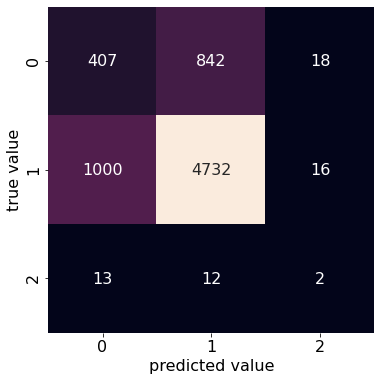

In [ ]:
cm_dt = confusion_matrix(y_valid, y_dt_valid)
show_confusion_matrix(cm_dt)

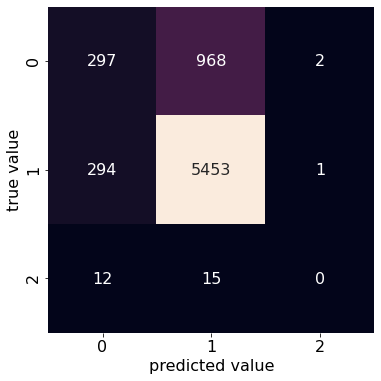

In [ ]:
cm_rf = confusion_matrix(y_valid, y_rf_valid)
show_confusion_matrix(cm_rf)

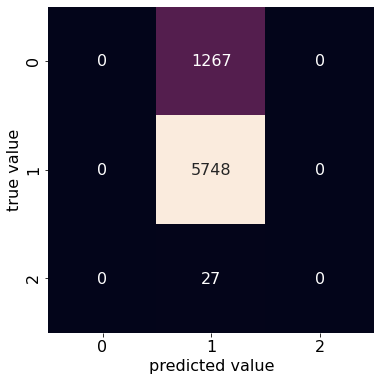

In [ ]:
cm_lda = confusion_matrix(y_valid, y_lda_valid)
show_confusion_matrix(cm_lda)

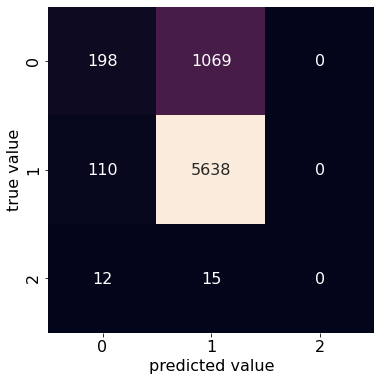

In [ ]:
cm_mlp = confusion_matrix(y_valid, y_mlp_valid)
show_confusion_matrix(cm_mlp)

# 4. MLFlow

# 5. Hiper Parametros

In [ ]:
tuned_parameters_rf = [{ 'criterion': ['gini', 'entropy'],
                         'max_features' : ['auto', 'sqrt', 'log2'],
                        'class_weight' : ['balanced', 'balanced_subsample']
                         }]

tuned_parameters_mlp = [{'solver' : ['lbfgs', 'sgd', 'adam'],
                         'alpha' : [0.0001, 0.05],
                         'learning_rate': ['constant','adaptive'],
                         }]

In [ ]:
rf = RandomForestClassifier(n_estimators=260, oob_score=True, n_jobs=-1, random_state=42, bootstrap=True)
mlp = MLPClassifier(random_state=42)
knn = KNeighborsClassifier(n_jobs=-1)

In [ ]:
clf_mlp = GridSearchCV(mlp, tuned_parameters_mlp, cv=kfold)
clf_mlp.fit(X_train, y_train)
joblib.dump(clf_mlp, './clf_mlp_us.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

['./clf_mlp_us.pkl']

In [ ]:
print("Melhores param MLP:")
print(clf_mlp.best_params_)
print("\nModelo Otimo:", round(clf_mlp.score(X_valid, y_valid), 4))

Melhores param MLP:
{'alpha': 0.05, 'learning_rate': 'constant', 'solver': 'adam'}

Modelo Otimo: 0.836


In [ ]:
clf_rf = GridSearchCV(rf, tuned_parameters_rf, cv=kfold)
clf_rf.fit(X_train, y_train)
joblib.dump(clf_rf, './clf_rf_us.pkl')

['./clf_rf_us.pkl']

In [ ]:
print("Melhores param RF:")
print(clf_rf.best_params_)
print("\nModelo Otimo:", round(clf_rf.score(X_valid, y_valid), 4))

Melhores param RF:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'auto'}

Modelo Otimo: 0.8106


In [ ]:
y_knn_train_tweaked = clf_knn.predict(X_train)
y_knn_valid_tweaked = clf_knn.predict(X_valid)
y_knn_test_tweaked = clf_knn.predict(X_test)

In [ ]:
y_mlp_train_tweaked = clf_mlp.predict(X_train)
y_mlp_valid_tweaked = clf_mlp.predict(X_valid)
y_mlp_test_tweaked = clf_mlp.predict(X_test)

In [ ]:
gain_train_rf = round((accuracy_score(y_train, y_rf_train_tweaked) - accuracy_score(y_train, y_rf_train))*100, 3)
gain_train_mlp = round((accuracy_score(y_train, y_mlp_train_tweaked) - accuracy_score(y_train, y_mlp_train))*100, 3)

gain_valid_rf = round((accuracy_score(y_valid, y_rf_valid_tweaked) - accuracy_score(y_valid, y_rf_valid))*100, 3)
gain_valid_mlp = round((accuracy_score(y_valid, y_mlp_valid_tweaked) - accuracy_score(y_valid, y_mlp_valid))*100, 3)



print("rf:         \n - Train: {0} + ({1})\n - Valid: {2} + ({3})".format(round(accuracy_score(y_train, y_rf_train_tweaked)*100, 3), gain_train_rf,
                                                                                                  round(accuracy_score(y_valid, y_rf_valid_tweaked)*100, 3), gain_valid_rf))

print("MLP:         \n - Train: {0} + ({1})\n - Valid: {2} + ({3})".format(round(accuracy_score(y_train, y_mlp_train_tweaked)*100, 3), gain_train_mlp,
                                                                                                  round(accuracy_score(y_valid, y_mlp_valid_tweaked)*100, 3), gain_valid_mlp))

rf:         
 - Train: 97.827 + (-0.151)
 - Valid: 81.057 + (-0.596)
MLP:         
 - Train: 83.296 + (0.549)
 - Valid: 83.598 + (0.724)


## Graficos

81.05651803464924

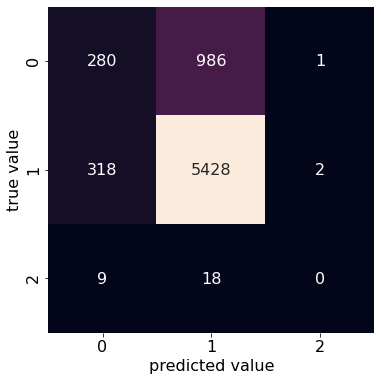

In [ ]:
cm_rf_tweak = confusion_matrix(y_valid, y_rf_valid_tweaked)
show_confusion_matrix(cm_rf_tweak)
accuracy_score(y_valid, y_rf_valid_tweaked)*100

81.158597188698

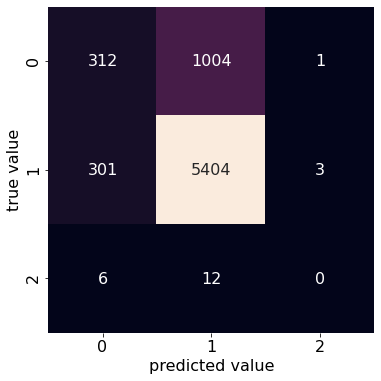

In [ ]:
cm_rf_tweakt = confusion_matrix(y_test, y_rf_test_tweaked)
show_confusion_matrix(cm_rf_tweakt)
accuracy_score(y_test, y_rf_test_tweaked)*100

83.59840954274354

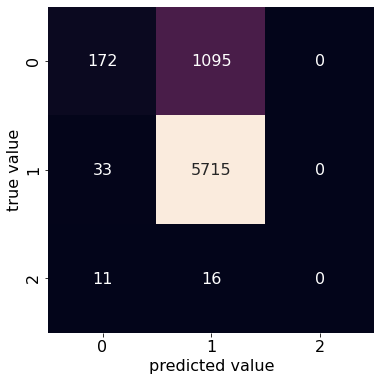

In [ ]:
cm_mlp_tweak = confusion_matrix(y_valid, y_mlp_valid_tweaked)
show_confusion_matrix(cm_mlp_tweak)
accuracy_score(y_valid, y_mlp_valid_tweaked)*100

83.08959250319467

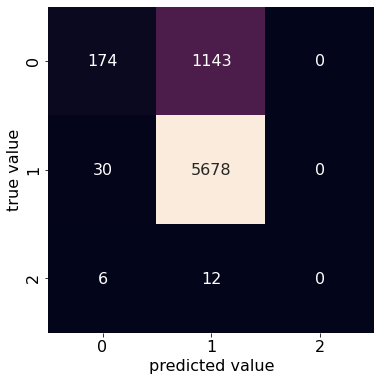

In [ ]:
cm_mlp_tweakt = confusion_matrix(y_test, y_mlp_test_tweaked)
show_confusion_matrix(cm_mlp_tweakt)
accuracy_score(y_test, y_mlp_test_tweaked)*100

In [ ]:
clf_rf.estimator.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=260,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_valid = clf_rf.estimator.predict(X_valid)
rf_test =clf_rf.estimator.predict(X_test)

In [ ]:
accuracy_score(y_valid, rf_valid)

0.8135472877023573

In [ ]:
accuracy_score(y_test, rf_test)

0.8161294902740309

In [ ]:
kfold = KFold(n_splits=10, random_state=random_seed, shuffle=True)

results_rf = cross_val_score(clf_rf.estimator, X_train, y_train, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f%% (%.3f%%)" % (results_rf.mean()*100.0, results_rf.std()*100.0))

Accuracy: 81.872% (0.676%)


In [ ]:
clf_rf.estimator

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=260,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

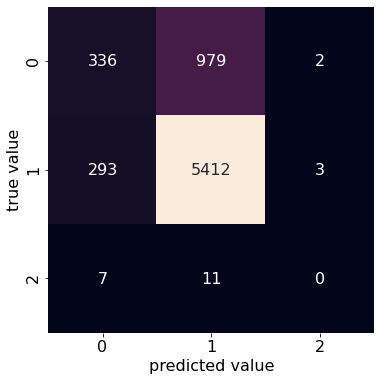

In [ ]:
cm_rf_tweakd = confusion_matrix(y_test, rf_test)
show_confusion_matrix(cm_rf_tweakd)

## Feature Importance
Com o feature importance, descobrimos que 'ano' é uma feature com poquissima relevancia, todavia remove-la ocasionou em poquissimo ganho de acuracia.


Feature ranking:
1. feature 0 (0.324102)
2. feature 4 (0.195456)
3. feature 3 (0.191854)
4. feature 1 (0.177347)
5. feature 2 (0.111240)


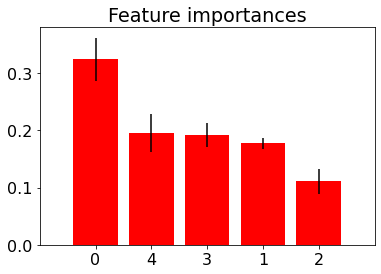

In [ ]:
importances = clf_rf.estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# 6. Diagnostico do Modelo Random Forests
Escolhemos Random Forests por que apesar de apresentar uma acuracia menor do que o Multi-Layer Perceptron ele tem um comportamento menos desequilibrado (MLP praticamente classifica sempre como 'Com Vitima')

In [ ]:
rf = clf_rf.estimator
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=260,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
joblib.dump(rf, './rf_only.pkl')

['./rf_only.pkl']

# Clustering

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [ ]:
X, y = get_values(dados_acidentes)

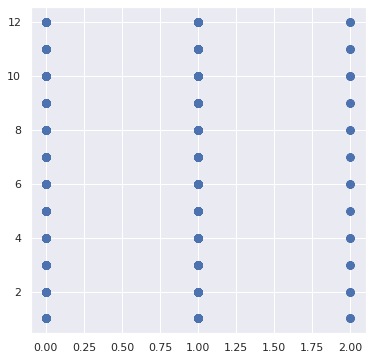

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y, X[:, 3], s=50);

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

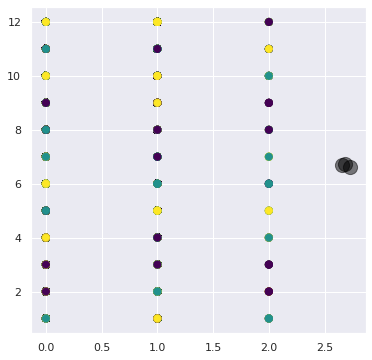

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y, X[:, 3], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='black', s=200, alpha=0.5);